# Importer les librairies nécessaires
* numpy: pour la manipulation des matrices
* PIL: pour lire les images
* os: pour manipuler le système de fichier
* matplotlib.pyplot: pour faire les diagrammes

In [ ]:
import numpy as np 
from PIL import Image 
import os 
import matplotlib.pyplot as plt 

# afficher un exemple d'une cellule infectée

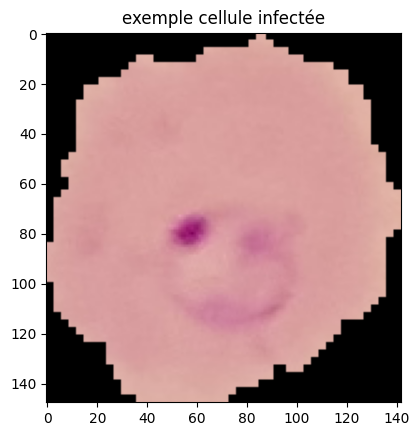

In [ ]:
img_path1 = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"

img1 = Image.open(img_path1)
plt.imshow(img1)
plt.title("exemple cellule infectée")
plt.show()

# afficher un exemple d'une cellule non infectée

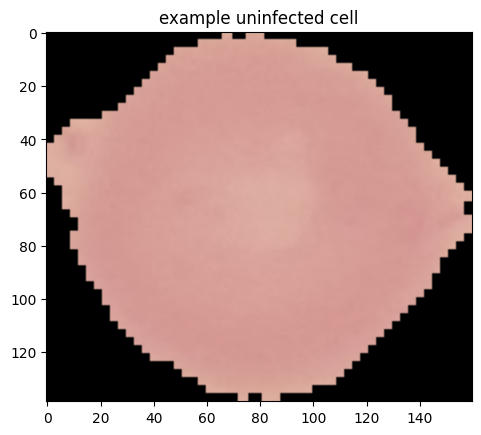

In [ ]:
img_path2 = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png"

img2 = Image.open(img_path2)
plt.imshow(img2)
plt.title("example cellule non infecté")
plt.show()

# Lire les images du dataset

In [ ]:
#chemin gloabl
path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"

images = [] #vecteur des entrées
labels = [] #vecteur des sorties (classes)

infected_dir = os.listdir(f"{path}/Parasitized/") #chemin des images des cellules infectées
uninfected_dir = os.listdir(f"{path}/Uninfected/") #chemin des images des cellules non infectées


for file in infected_dir: #pour chaque fichier
    if file.endswith(".png"): #si le fichier possède l'extension "png" donc c'est une image
        img = Image.open(f"{path}/Parasitized/{file}") #lire l'image
        img = img.resize((100,100)) #changer les dimensions de l'image à (100,100) pour assurer que tous les images sont de même taille
        img_arr = np.array(img) # transformer l'image en une matrice
        images.append(img_arr) #ajouter l'image au vecteur des entrées
        labels.append(1) #ajouter la classe "1" au vecteur des sorties (classes)
    

for file in uninfected_dir: #pour chaque fichier
    if file.endswith(".png"): #si le fichier possède l'extension "png" donc c'est une image
        img = Image.open(f"{path}/Uninfected/{file}") #lire l'image
        img = img.resize((100,100)) #changer les dimensions de l'image à (100,100)
        img_arr = np.array(img) # transformer l'image en une matrice
        images.append(img_arr) #ajouter l'image au vecteur des entrées
        labels.append(0) #ajouter la classe "0" au vecteur des sorties (classes)

    
    
X = np.array(images) #construire le vecteur X
Y = np.array(labels) #construire le vecteur Y

print("dimensions de X:", X.shape)
print("dimensions de Y", Y.shape)

(27558, 100, 100, 3)
(27558,)


# diviser le dataset pour l'entrainement et le test

In [ ]:
from sklearn.model_selection import train_test_split

X = X / 255.0 # normaliser les images car les valeurs varient de 0 à 255

# prendre 30% du dataset pour le test et 70% pour l'entrainement
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print("dimensions de X_train:", X_train.shape)
print("dimensions de X_test:", X_test.shape)
print("dimensions de Y_train:", Y_train.shape)
print("dimensions de Y_test:", Y_test.shape)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


dimensions de X_train: (19290, 100, 100, 3)
dimensions de X_test: (8268, 100, 100, 3)
dimensions de Y_train: (19290,)
dimensions de Y_test: (8268,)


# Definition du model

In [ ]:
from tensorflow.keras import Sequential #le type du modèle
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense #les couches utilisées
import tensorflow as tf
import time  #pour calculer le temps d'execution


strategy = tf.distribute.MirroredStrategy() #initialiser le mode parallèle
model = None

with strategy.scope():# commencer en mode parllèle
    model = Sequential([#definir le modèle
        Conv2D(32, (3,3), activation="relu", input_shape=(100,100,3)),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation="relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    #
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    
start_time = time.time()
history = model.fit(X_train, Y_train, epochs=5, validation_split=0.2)
end_time = time.time()

exec_time = end_time - start_time
print(f"temps d'execution parallèle: {exec_time}s")

Epoch 1/5
483/483 [==============================] - 140s 280ms/step - loss: 0.3978 - accuracy: 0.8022 - val_loss: 0.2339 - val_accuracy: 0.9233
Epoch 2/5
483/483 [==============================] - 126s 260ms/step - loss: 0.1649 - accuracy: 0.9479 - val_loss: 0.1502 - val_accuracy: 0.9539
Epoch 3/5
483/483 [==============================] - 125s 260ms/step - loss: 0.1421 - accuracy: 0.9541 - val_loss: 0.1347 - val_accuracy: 0.9546
Epoch 4/5
483/483 [==============================] - 123s 256ms/step - loss: 0.1239 - accuracy: 0.9578 - val_loss: 0.1363 - val_accuracy: 0.9570
Epoch 5/5
483/483 [==============================] - 123s 255ms/step - loss: 0.1094 - accuracy: 0.9627 - val_loss: 0.1323 - val_accuracy: 0.9562
temps d'execution parallèle: 643.2518465518951s


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 32)       0

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(100,100,3)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
history = model.fit(X_train, Y_train, epochs=5, validation_split=0.2)
end_time = time.time()

exec_time = end_time - start_time
print(f"temps d'execution sequentiele: {exec_time}s")

Epoch 1/5
483/483 [==============================] - 123s 252ms/step - loss: 0.4320 - accuracy: 0.7722 - val_loss: 0.1734 - val_accuracy: 0.9453
Epoch 2/5
483/483 [==============================] - 120s 249ms/step - loss: 0.1649 - accuracy: 0.9467 - val_loss: 0.2110 - val_accuracy: 0.9562
Epoch 3/5
483/483 [==============================] - 119s 247ms/step - loss: 0.1391 - accuracy: 0.9552 - val_loss: 0.1332 - val_accuracy: 0.9552
Epoch 4/5
483/483 [==============================] - 120s 249ms/step - loss: 0.1212 - accuracy: 0.9596 - val_loss: 0.1398 - val_accuracy: 0.9552
Epoch 5/5
483/483 [==============================] - 121s 250ms/step - loss: 0.1098 - accuracy: 0.9625 - val_loss: 0.1322 - val_accuracy: 0.9580
temps d'execution sequentiele: 625.8651993274689s


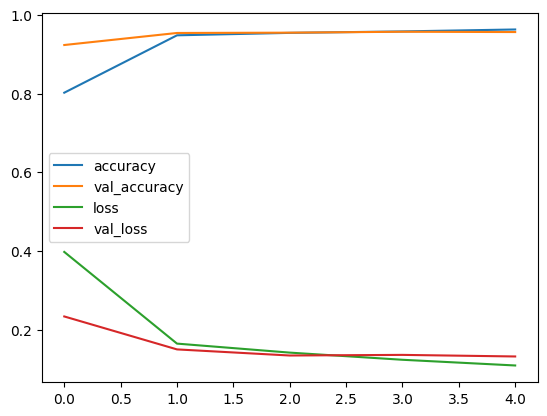

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'], loc='center left')
plt.show()

# Tester le modèle

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('précision:', test_acc)
print("erreur:", test_loss)

259/259 [==============================] - 17s 65ms/step - loss: 0.1324 - accuracy: 0.9562
précision: 0.9562167525291443
erreur: 0.1324065774679184


# Matrice de confusion

259/259 [==============================] - 16s 58ms/step


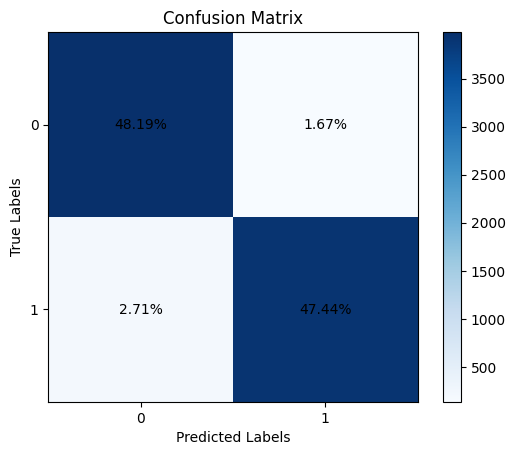

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test)
threshold = 0.5



y_pred = (y_pred_prob > threshold).astype(int).flatten()
confusion = confusion_matrix(Y_test, y_pred)
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0, 1])
plt.yticks([0, 1])



total_samples = np.sum(confusion)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        percentage = confusion[i, j] / total_samples * 100
        plt.text(j, i, f'{percentage:.2f}%', horizontalalignment='center', verticalalignment='center')

plt.show()
